# Principal Component Analysis (PCA) 

~~~
Extracción de Características en Imágenes.
Master en Ciencia de Datos e Ingeniería de Computadores.
Universidad de Granada.

Francisco Javier Sáez Maldonado - fjaviersaezm@ugr.es
Rafael Molina Soriano - rms@decsai.ugr.es

Créditos: Francisco Miguel Castro Macías, Fernando Pérez Bueno
~~~

Vamos a utilizar el análisis de componentes principales (Principal Component Analysis, PCA) sobre una base de datos de caras para reducir la dimensionalidad de cada cara extrayendo un conjunto de variables latentes. Estas variables latentes podrían, con posterioridad, utilizarse, por ejemplo, en problemas de clasificación siempre que los errores de reconstrucción de las caras usando las variables latentes fuese pequeño. También podrían usarse en problemas de detección de anomalías.

El fichero ERRDfaces.mat contiene una base de datos de caras almacenada por filas en la matriz `X`. Cada fila corresponde a una cara de 32x32=1024 píxeles en niveles de gris. El número de ejemplos es 5000.

Comenzamos importando las librerías que vamos a utilizar en el desarrollo de la práctica.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

Especificamos la ruta donde están nuestros datos y los leemos. Observa la estructura que los contiene. Lee la documentación sobre la función `loadmat`.

In [2]:
path='./'

dict_data = loadmat(path+'ERRDfaces_2021.mat')
print(dict)

<class 'dict'>


Como ves, los datos están almacenados en un diccionario. Extraemos nuestros datos usando la llave `X` y mostramos su dimensión.

In [3]:
data= dict_data['X']
data.shape

(5000, 1024)

Usaremos las 4.500 primeras caras como ejemplos de entrenamiento y las restantes 500 como test. El conjunto de test nos servirá para probar que PCA representa suficientemente bien la información como para aplicarlo a datos que no ha visto.

Dependiendo del problema podríamos usar todas las muestras como conjunto de entrenamiento. Por ejemplo, si quisiéramos detectar anomalías en el conjunto de imagenes, debemos usar un conjunto "de calibración".

> 📝 **Pregunta 1.** Completa el código para que la variable `X` siguiente contenga las 4500 primeras caras de `data` y `test` el resto.

In [4]:
N_tr = 4500
X = data[:4500]
test = data[4500:]

Las caras están almacenadas como un vector de rasgos, donde cada imagen es una única fila. 

> 📝 **Pregunta 2.** Redimensiona, es decir, pasa de un vector con 1024 componentes a una matriz 32x32, y muestra las 5 primeras caras del dataset. Pueden resultarte utiles las funciones `np.reshape` y `plt.imshow`. Tal vez necesites trasponer la matriz que contiene la cara.

<Figure size 1500x800 with 0 Axes>

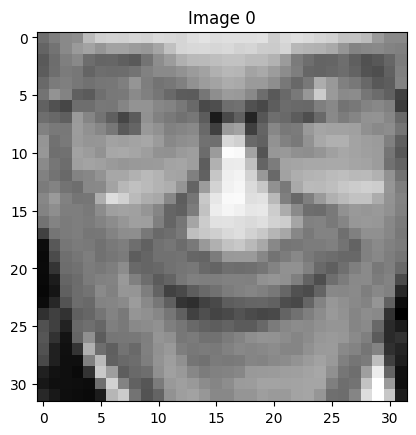

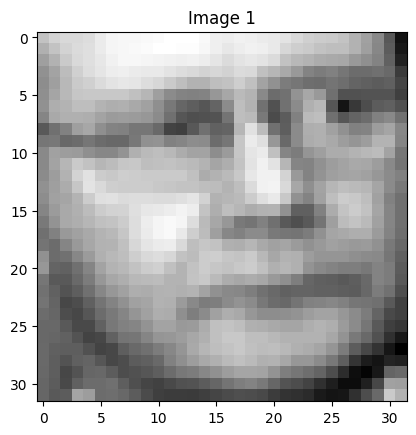

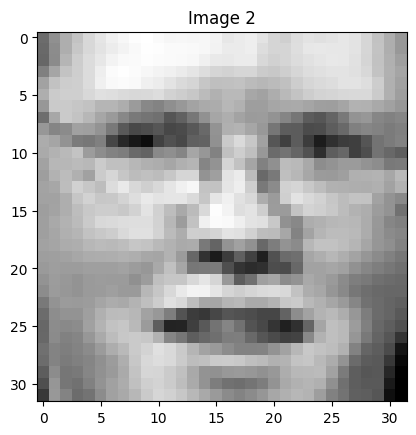

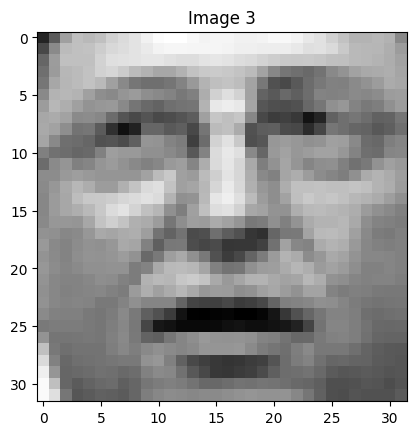

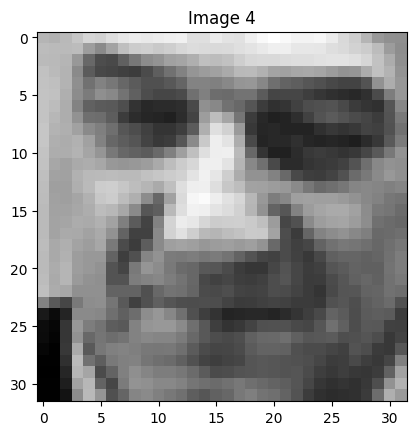

In [5]:
n_caras = 5
plt.figure(figsize=(15,8))

# Redimensionamos los datos
X = np.reshape(X, (X.shape[0], 32, 32))

# Los mostramos
for i in range(n_caras):
    plt.figure()
    # Se transpone la matriz para mostrar la cara orientada y se utiliza el mapa de colores gris
    plt.imshow(X[i].T, cmap="gray") 
    plt.title(f"Image {i}")

# Normalización de los datos 

Para trabajar con modelos como PCA, es necesario normalizar los datos. Recuerda una de las primeras cosas que comentó Rafa:
\begin{equation*}
\mathbf{x} \approx \mathbf{\phi} \mathbf{z} \color{red}{+ \boldsymbol{\mu}}
\end{equation*}
"Nosotros supondremos que $\color{red}{\boldsymbol{\mu}=\boldsymbol{0}}$"

> 📝 **Pregunta 3.** Usando la clase `StandardScaler` de sklearn normaliza los datos de entrenamiento, de forma que cada rasgo (de los 1024) tenga media cero. No realices el escalado de la varianza a uno. Los rasgos normalizados deberás almacenarlos en la variable `X_norm`. Ten en cuenta que más tarde tendrás que aplicar la misma normalización a los datos de test.

In [6]:
from sklearn.preprocessing import StandardScaler

X = np.reshape(X, shape = (X.shape[0], X.shape[1]**2))
scaler = StandardScaler(with_std=False)
scaler.fit(X)
X_norm = scaler.transform(X)

> 📝 **Pregunta 4.** Escribe código, lo más eficiente posible, para comprobar que las columnas de rasgos tienen media cero.

In [7]:
# Si la media en el eje 0 es cero, devuelve TRUE
print(not np.all(X_norm.mean(axis=0)))

True


# Cálculo de las PCAs 

Una vez que has normalizado los datos. Utilizaremos `X_norm` para calcular las componentes principales. Aunque existe una función implementada en el paquete sklearn nosotros no la utilizaremos para comprender en profundidad el funcionamiento de PCAs. No se considera válido para el desarrollo de la práctica el uso de implementaciones de PCA en sklearn o cualquier otra libreria.

Supongamos que $\mathbf{X} \in \mathbb{R}^{N \times D}$ y que queremos proyectar nuestros datos en un espacio de dimensión $M$. Recuerda que el cálculo de las componentes principales viene dado por la solución al problema
$$ \min_{\mathbf{W} \in \mathbb{R}^{D \times M}, \mathbf{Z} \in \mathbb{R}^{N \times M}} \| \mathbf{X}^\top - \mathbf{W}\mathbf{Z}^\top\|_F^2.$$
En teoría hemos visto que tal solución viene dada tomando
$$ \mathbf{W} = \mathrm{Eigenvec}(\mathbf{S})_M, \quad \mathbf{Z}^\top = \mathbf{W}^\top \mathbf{X}^\top$$
donde $\mathrm{Eigenvec}(\mathbf{S})_M$ contiene los $M$ autovectores (vectores propios) con mayores autovalores (valores propios) de la matriz de covarianza muestral $\mathbf{S} = (1/N) \mathbf{X}^\top \mathbf{X}$. La reconstrucción se realiza tomando 
$$ \hat{\mathbf{X}}^\top =  \mathbf{W} \mathbf{Z}^\top.$$

Para calcular las componentes principales necesitamos calcular los autovectores de $\mathbf{X}^\top \mathbf{X}$. En teoría hemos visto que se pueden calcular a partir de la descomposición en valores singurales $\mathbf{X}^\top = \mathbf{V} \mathbf{D} \mathbf{U}^\top$. Tenemos que 
$$ \mathbf{S} = \frac{1}{N} \mathbf{V} \mathbf{D}^2 \mathbf{V}^\top,$$
lo que significa que los autovectores de $\mathbf{S}$ se encuentran en las columnas de $\mathbf{V}$ y los autovalores vienen dados por $\lambda_i = (1/N) \mathbf{D}_{ii}^2$. Recuerda que $\mathbf{D}$ es una matriz diagonal.

> 📝 **Pregunta 5.** Utiliza la descomposición por valores sigulares sobre `X_norm` o `X_norm` traspuesta usando la función `np.linalg.svd()`. Obtén los autovectores y con los valores singulares calcula los autovalores. Alternativamente, puedes calcular los autovectores y autovalores de la matriz de covarianza muestral de `X_norm` utilizando la función `np.linalg.eig()`. Tal vez sería bueno que lo hicieras con los dos métodos y comprobases que obtienes los mismos autovalores.

In [8]:
U, D, V = np.linalg.svd(X_norm, full_matrices=False)
eigen_vectors = V
eigen_values = (D**2) / X_norm.shape[0]

# Obtenemos los índices ordenados
indexes = np.argsort(eigen_values)[::-1]

# Introduce en autovalores los autovalores (ordenados) de la matriz de covarianza muestral
autovalores = eigen_values[indexes]

# Introduce en autovectores los vectores (ordenados) que definen la transformación de PCA
autovectores = eigen_vectors[:, indexes].T

# Ahora comprobamos que son los mismos resultados que usando np.linalg.eig()
S = np.dot(X_norm.T, X_norm) / X_norm.shape[0]
eigen_values_np, eigen_vectors_np = np.linalg.eig(S)

# Los ordenamos de mayor a menor
indexes_np = np.argsort(eigen_values_np)[::-1]
eigen_values_np = eigen_values_np[indexes_np]
eigen_vectors_np = eigen_vectors_np[:, indexes_np]

# Comparamos si son iguales
print("Eigenvalues are equal:", np.allclose(autovalores, eigen_values_np))
print(
    "Eigenvectors are equal:",
    np.allclose(np.abs(autovectores), np.abs(eigen_vectors_np)),
)
print("SVD eigenvectors shape:", autovectores.shape)
print("Direct eigenvectors shape:", eigen_vectors_np.shape)


Eigenvalues are equal: True
Eigenvectors are equal: True
SVD eigenvectors shape: (1024, 1024)
Direct eigenvectors shape: (1024, 1024)


## Nota
- Los vectores propios (eigenvectors) calculados en ambos métodos pueden diferir en el signo porque hay una ambigüedad inherente en su cálculo, de todas formas son equivalentes, por ello se utiliza np.abs().

# Número de componentes a utilizar

Vamos ahora a determinar cuantas componentes vamos a utilizar en nuestro analisis. Cada componente adicional explica parte de la varianza de nuestros datos. Queremos encontrar cuántas componentes son necesarias para representar bien nuestros datos. 

Usando los autovalores que hemos obtenido, podemos observar qué cantidad de información aporta cada una de las componentes. Las dos gráficas a continuación muestran esta información de dos formas diferentes.

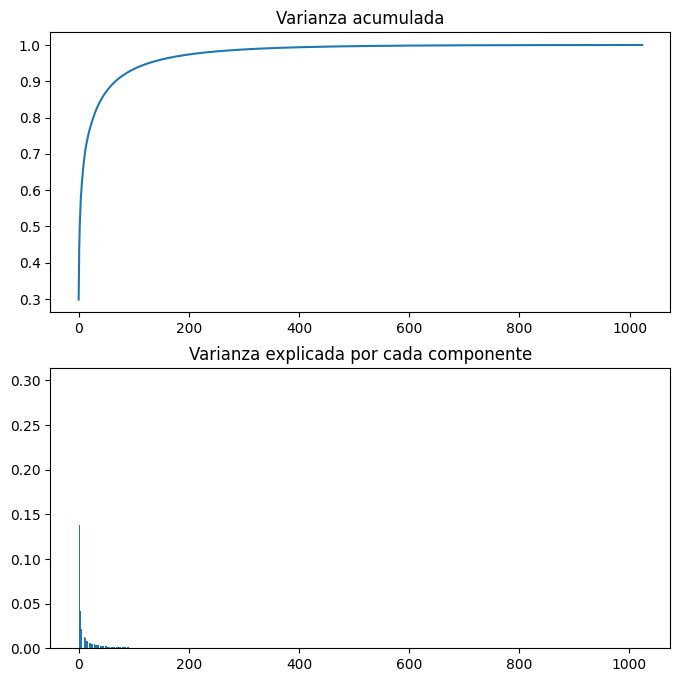

In [9]:
import matplotlib.pyplot as plt

#Hacemos uso de la suma acumulada de los autovalores para ver la varianza acumulada
cumsum=np.cumsum(autovalores)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(cumsum/cumsum[-1])
plt.title('Varianza acumulada')
plt.subplot(2,1,2)
#El aporte de cada autovalor a la suma total, nos muestra la varianza explicada por cada componente
plt.bar(range(autovalores.shape[0]),autovalores/np.sum(autovalores))
plt.title('Varianza explicada por cada componente')
plt.show()

Aunque podemos fijar el número de componentes manualmente tras estudiar los datos, es bueno que pienses como determinarías automáticamente el número de componentes a utilizar.

> 📝 **Pregunta 6.** ¿Qué harías para determinar cuál sería un buen número de componentes? Justifica tu respuesta. No es necesario que lo implementes.

> **Respuesta:**
Si usar validación cruzada con $k$ capas y determinar cuál es un número adecuado de componentes es manual, lo que yo haría sería establecer un umbral de varianza explicada. Un valor por debajo de ese umbral sería insuficiente y por tanto se obtendrían las $N$ componentes mínimas que lo superen o igualen.
Otra opción que se me ocurre sería usar un método parecido al del **criterio del codo**. Se añaden componentes iterativamente y si la componente $i+1$, es decir, la siguiente componente, no aporta un mínimo (determinado por un umbral preestablecido) de varianza explicada, no se añade. Sería un método por el que se podría graficar una línea con un "codo", siendo este punto donde deja de merecer la pena añadir más componentes.

# Visualización de las autocaras

En el caso de las caras, se puede apreciar muy bien la información que captura cada una de las componentes principales visualizando las llamadas autocaras que no son más que los autovectores. Cada uno de los autovectores que hemos calculado representa elementos clave de una cara que pueden utilizarse para componer la imagen final.

> 📝 **Pregunta 7.** Igual que hiciste con las imágenes, escribe aquí código que permita visualizar los primeros 5 autovectores en forma de imagen. Es decir, los 5 autovectores asociados a los 5 autovalores mayores. Tendrás que redimensionar los vectores para darles formato de imagen.

<Figure size 1500x800 with 0 Axes>

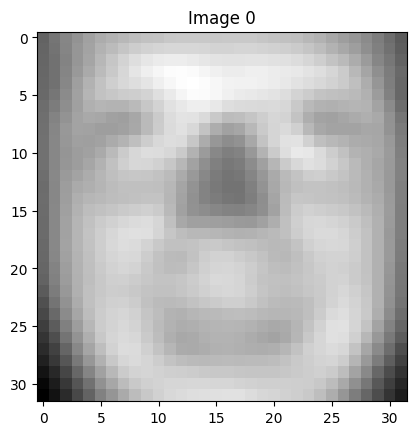

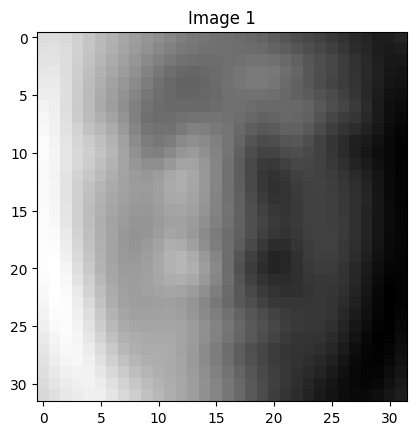

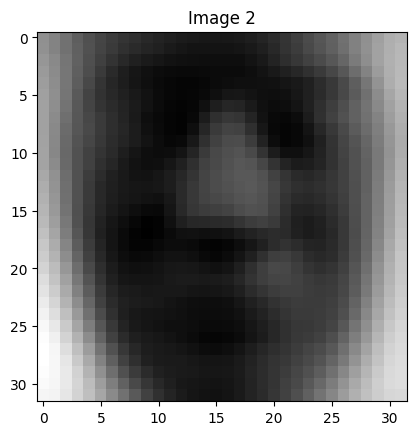

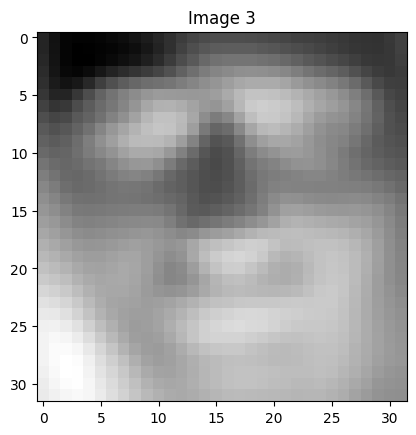

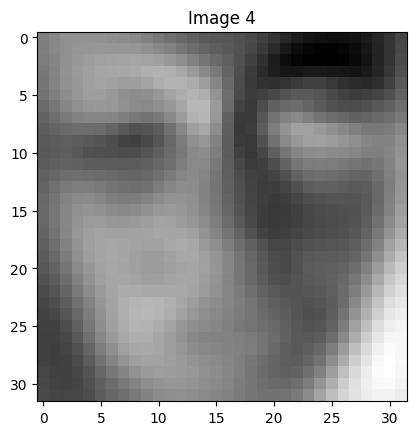

In [10]:
#Introduce aquí tu código para representar las 5 primeras autocaras
first_five_autocaras = autovectores[:, :5].T
n_autocaras = 5
plt.figure(figsize=(15,8))

# Redimensionamos los datos
first_five_autocaras = np.reshape(first_five_autocaras, (first_five_autocaras.shape[0], 32, 32))

# Los mostramos
for i in range(n_autocaras):
    plt.figure()
    # Se transpone la matriz para mostrar la cara orientada y se utiliza el mapa de colores gris
    plt.imshow(first_five_autocaras[i].T, cmap="gray") 
    plt.title(f"Image {i}")



> 📝 **Pregunta 8.** Escribe aquí el código que permita visulizar los cinco últimos 5 autovectores en forma de imagen. Es decir, los 5 autovectores asociados a los 5 menores autovalores.

<Figure size 1500x800 with 0 Axes>

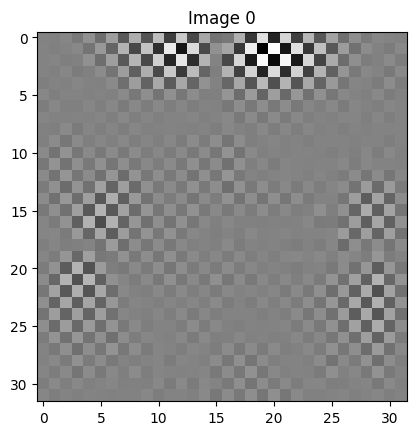

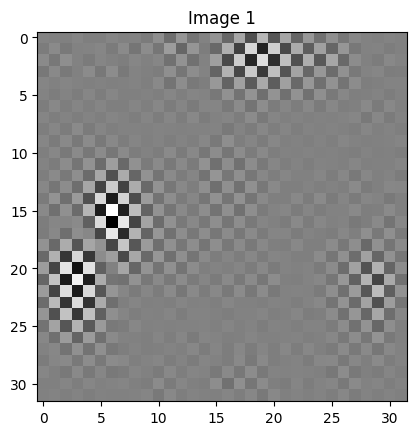

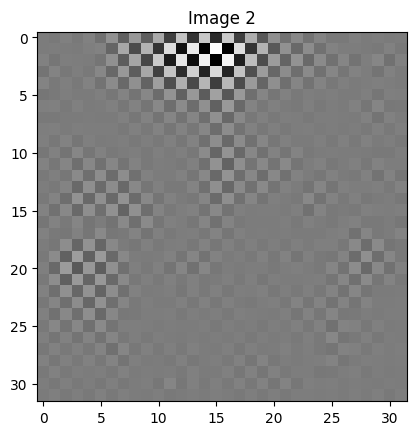

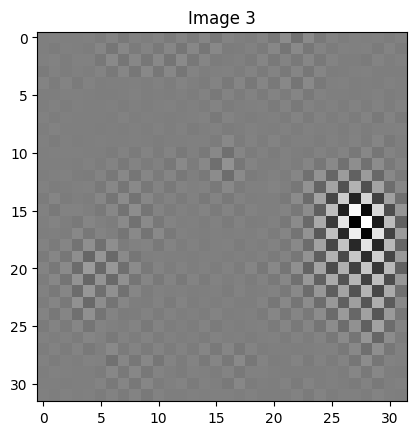

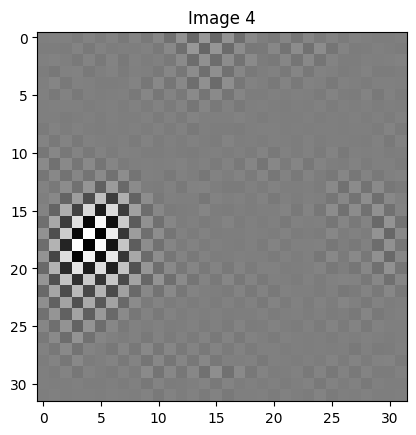

In [11]:
#Introduce aquí tu código para representar las 5 últimas

first_five_autocaras = autovectores[:, -5:].T
n_autocaras = 5
plt.figure(figsize=(15,8))

# Redimensionamos los datos
first_five_autocaras = np.reshape(first_five_autocaras, (first_five_autocaras.shape[0], 32, 32))

# Los mostramos
for i in range(n_autocaras):
    plt.figure()
    # Se transpone la matriz para mostrar la cara orientada y se utiliza el mapa de colores gris
    plt.imshow(first_five_autocaras[i].T, cmap="gray") 
    plt.title(f"Image {i}")

> 📝 **Pregunta 9.** ¿Por qué son tan diferentes? 

> **Respuesta:**
Al ordenar los autovectores en orden descendiente por el valor de sus correspondientes autovalores, lo que se está haciendo es escoger aquellas direcciones en el espacio que son representadas por los autovectores y, escoger las que tienen una mayor variación (los autovalores son escalares que representan cuanto varían los datos en ese autovector, en esa "dirección"). Por tanto, los autovectores que contienen menos información son aquellos que, una vez ordenados, se encuentran en las últimas posiciones, aquellos con un autovalor asociado mucho más pequeño.
Básicamente, a mayor variación en el espacio mayor información se puede extraer de esa dirección. Téngase en cuenta que una varianza de $0$ indicaría que todos los puntos sobre los que se mide la dispersión son idénticos.
Por ello al graficarlos, las autocaras con menos información explicada son las últimas, las que peor se ven y menos caras parecen. Las autocaras del principio son mucho más similares a una cara, ya que se han extraído los patrones subyacentes en el espacio que hacen que una cara se parezca exáctamente a eso, a una cara.

# Cálculo de las componentes principales de los datos

Hasta ahora hemos obtenido los vectores (autovectores o autocaras) que definen el subespacio donde vamos a proyectar los datos. También hemos visto qué cantidad de varianza explica cada autovector. 

Vamos a fijar el número de autocaras a 250, es decir `n_componentes=250`.

> 📝 **Pregunta 10.** Extrae de `V` los `n_componentes` autovectores asociados a los `n_componentes` mayores autovalores y almacénalos en `W`. A continuación obtén la proyección (variables latentes) de nuestros datos y almacénalos en `Z`. Observa que lo que estamos haciendo es proyectar nuestros datos originales `X_norm` en el espacio generado por los vectores de `W`.

In [12]:
n_componentes = 250

# W contendrá los autovectores correspondientes a las n_componentes principales

W = autovectores[:, :n_componentes]

# Z contendrá las proyecciones de nuestros datos en el espacio latente

Z = W.T.dot(X_norm.T)

print(Z.shape)

(250, 4500)


# Visualización de las primeras componentes

Podemos visualizar la primera y la segunda componentes para ver que información nos aportan sobre nuestros datos. 

> 📝 **Pregunta 11.** Crea dos gráficas separadas. Una que muestre solo la primera componente (variable latente) y otra que incluya las dos primeras (variables latentes) de todo el conjunto de entrenamiento.

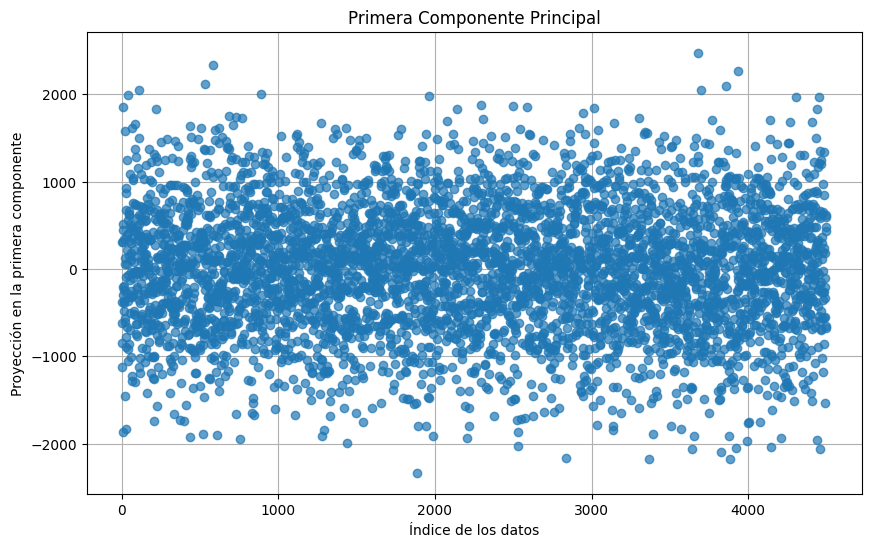

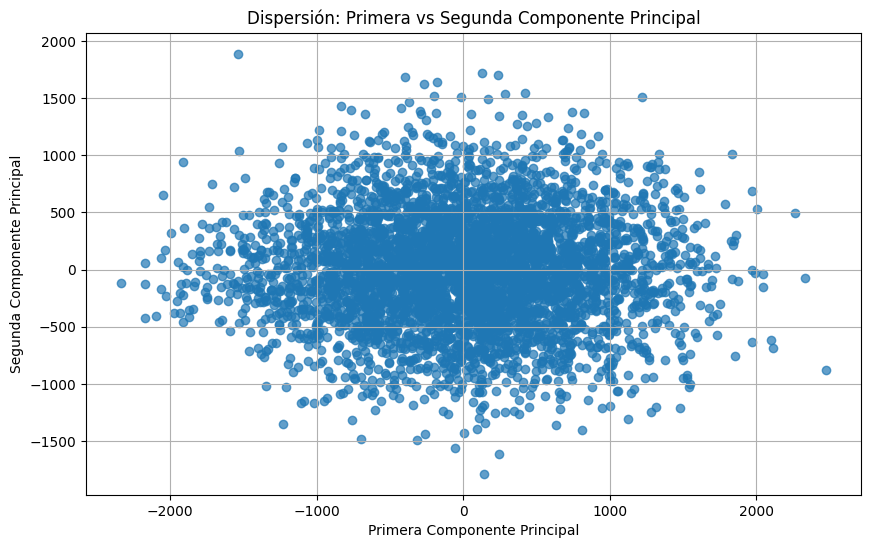

In [13]:
# Incluye aquí el código de la creación de las gráficas

pc1 = Z[0]
pc2 = Z[1]

plt.figure(figsize=(10, 6))
plt.plot(pc1, marker='o', linestyle='none', alpha=0.7)
plt.title("Primera Componente Principal")
plt.xlabel("Índice de los datos")
plt.ylabel("Proyección en la primera componente")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(pc1, pc2, alpha=0.7, marker='o')
plt.title("Dispersión: Primera vs Segunda Componente Principal")
plt.xlabel("Primera Componente Principal")
plt.ylabel("Segunda Componente Principal")
plt.grid(True)
plt.show()

> 📝 **Pregunta 12.** Comenta los resultados obtenidos.

> **Respuesta:** La primera componente es la que más información aporta, como puede verse en el segundo gráfico, donde su eje es el que más dispersión presenta. La distribución de la primera componente parece bastante uniforme, donde la mayoría de valores quedan representados entres $[-2000, 2000]$. No hay una tendencia clara a lo largo del índice, lo que sugiere que la primera componente principal captura variación que es consistente a través de todo el conjunto de datos. 
La forma de la primera componente frente a la segunda componente sugiere que no hay una correlación fuerte entre la primera y segunda componente principal, lo cual es esperado ya que las componentes principales son ortogonales por definición. De esta forma capturan patrones independientes.

# Recuperacion de los datos

A partir de las variables latentes almacenadas en `Z`, cada una de sus filas contiene la representación latente de cada uno de los ejemplos (filas) en `X_norm`, podemos reconstruir los datos. Observa que hemos pasado de 1024 rasgos a `n_componentes`. 

> 📝 **Pregunta 13.** Utiliza `Z` y los autovectores en `W` para reconstruir las caras originales. Ten en cuenta que tendrás que deshacer la normalización de los datos una vez hayas recuperado la dimensionalidad original.

In [14]:
#Introduce aquí tu código para recuperar los datos
print(W.shape)
print(Z.shape)
X_norm_recovered = W.dot(Z)
X_recovered = scaler.inverse_transform(X_norm_recovered.T)

(1024, 250)
(250, 4500)


> 📝 **Pregunta 14.** Muestra las 5 primeras caras de la base de datos original y su reconstrucción. Si has hecho los pasos correctamente, la reconstrucción debe ser similar al original.

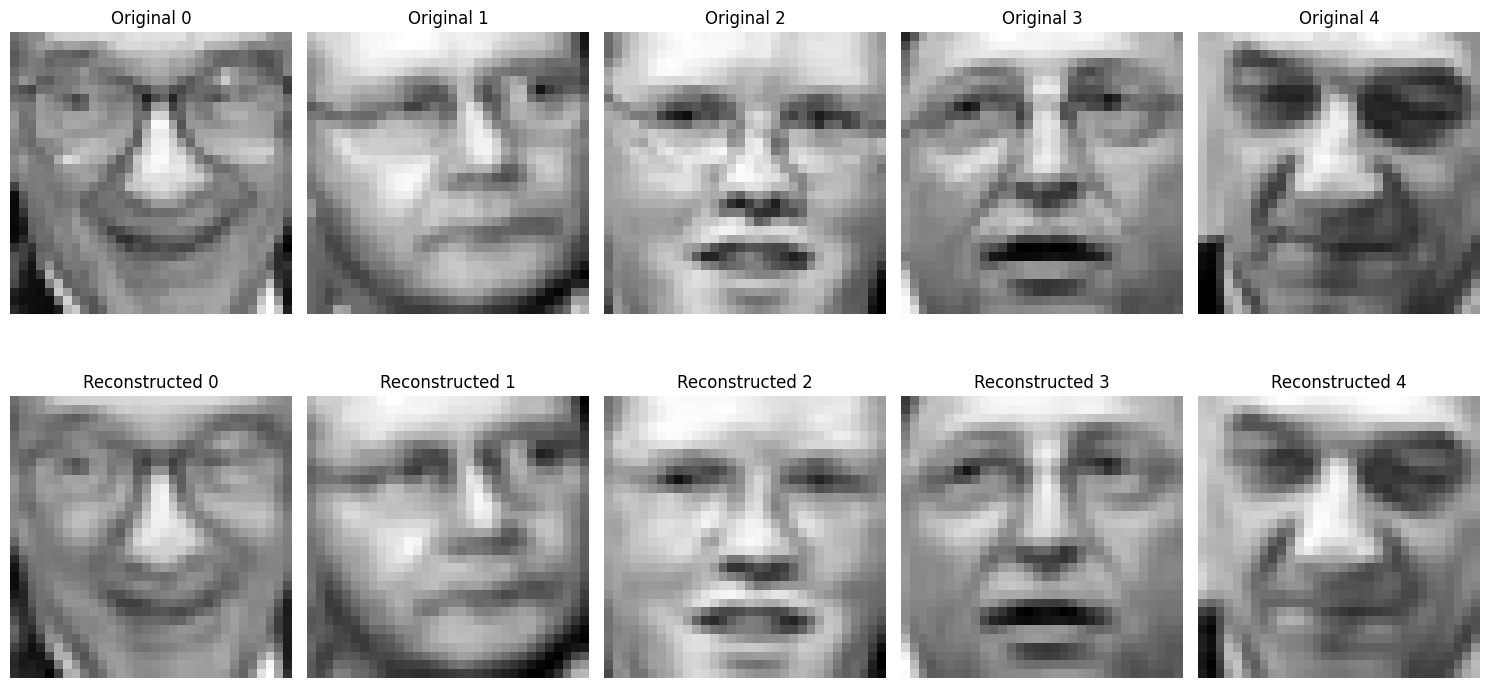

In [15]:
# Muestra 5 caras del dataset original y las mismas 5 caras reconstruidas

# Redimensionamos los datos
X = np.reshape(X, (X.shape[0], 32, 32))
X_recovered = np.reshape(X_recovered, (X_recovered.shape[0], 32, 32))

# Número de caras que se van a mostrar
n_caras = 5

plt.figure(figsize=(15, 8))

for i in range(n_caras):
    # Mostramos la imagen original
    plt.subplot(2, n_caras, i + 1)
    plt.imshow(X[i].T, cmap="gray")
    plt.title(f"Original {i}")
    plt.axis("off")

    # Mostramos la imagen reconstruida
    plt.subplot(2, n_caras, n_caras + i + 1)
    plt.imshow(X_recovered[i].T, cmap="gray")
    plt.title(f"Reconstructed {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


> 📝 **Pregunta 15.** ¿Qué ocurre si aumentamos o disminuímos el número `n_componentes`?

> **Respuesta:**
Al aumentar el número de componentes nos acercaremos más a las caras originales, pues cada componente extra añade información en la reconstrucción, cada componente tiene asociado un valor de varianza explicada sobre los datos originales. 
En cambio, si se reduce el número de componentes, las imágenes recontruidas se irán distorsionando cada vez más, pues se está disminuyendo la cantidad de varianza explicada, y por tanto, la información de lo que representa una cara en el espacio de dimensión $1024$ que se tiene originalmente. A mayor sea el número de componentes, mejor reconstrucción.

# Medición del error de reconstrucción

Según el número de componentes que hayamos utilizado, habremos perdido más o menos información. Podemos comprobarlo haciendo uso del error cuadratico medio (MSE). 

> 📝 **Pregunta 16.** Usando los datos originales de entrenamiento `X` y la reconstrucción que has obtenido, calcula el MSE que has cometido con cada una de las imágenes en `X`. 

In [16]:
#Introduce aquí tu código para calcular el MSE. Si lo has hecho bien, obtendrás un valor para cada elemento (fila) 
# de X.
mse = np.mean((X - X_recovered) ** 2, axis=(1,2))
print(mse.shape)

(4500,)


> 📝 **Pregunta 17.** Haciendo uso del error cuadrático medio identifica y muestra la imagen original y la reconstruida en los siguientes casos: la imagen peor reconstruida, la imagen mejor reconstruida.

2.191482210620661
154.29386720686594


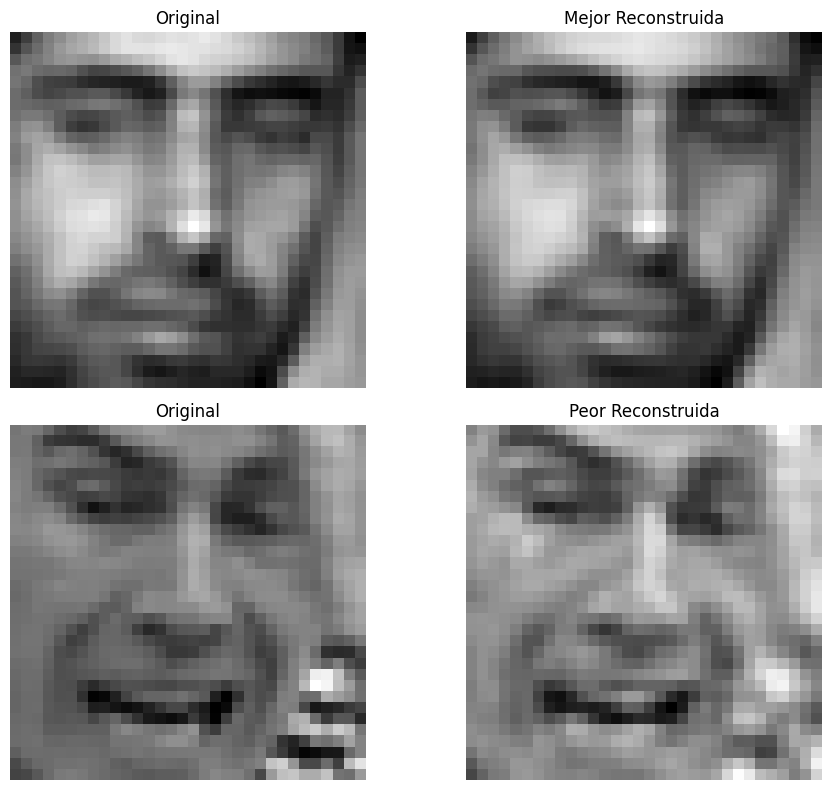

In [17]:
# Incluye el código para encontrar en el conjunto de entregamiento las imágenes peor y mejor reconstruidas usando el
# error cuadrático medio y muéstrales.

indexes_by_mse = np.argsort(mse)
best_img, best_img_reconstructed = X[indexes_by_mse[0]].T, X_recovered[indexes_by_mse[0]].T
worst_img, worst_img_reconstructed = X[indexes_by_mse[-1]].T, X_recovered[indexes_by_mse[-1]].T

print(mse[indexes_by_mse[0]])
print(mse[indexes_by_mse[-1]])

plt.figure(figsize=(10, 8))

# Mostramos las imágenes mejor reconstruidas
plt.subplot(2, 2, 1)
plt.imshow(best_img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(best_img_reconstructed, cmap="gray")
plt.title("Mejor Reconstruida")
plt.axis("off")

# Mostramos las imágenes peor reconstruidas
plt.subplot(2, 2, 3)
plt.imshow(worst_img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(worst_img_reconstructed, cmap="gray")
plt.title("Peor Reconstruida")
plt.axis("off")

plt.tight_layout()
plt.show()

> 📝 **Pregunta 18.** ¿Podrías explicar por qué son estas las caras que aparecen?

> **Respuesta:** La cara peor reconstruida, con mayor error **MSE** es esta debido a objetos extraños en la imagen, como es el caso del fondo distorsionado. Al haberse extraido características de los patrones subyacentes de las caras de forma exclusiva, otro tipo de patrones no son capturados y por tanto dicha información se distorsiona y se pierde durante el proceso de transformación. A mayor sea la cantidad de ruido o de patrones extraños en una imagen, como es el caso de la cara peor reconstruida, mayor será el error cuadrático medio. Además ha de añadirse que la peor reconstruida presenta rasgos faciales más expresivos y menos comunes en el dataset, mientras que la mejor reconstruida muestra rasgos más suaves y generales. La primera también posee un fondo, pero sin patrones irregulares, es mucho más plano.

# Aplicando el modelo a datos nuevos 

Los autovectores o autocaras que hemos encontrado haciendo uso de `X` deberian ser suficientemente buenos para representar otros datos del mismo tipo. Vamos a comprobarlo haciendo uso del pequeño conjunto de test que separamos al principio de la práctica.

Utilizando los autovectores que ya has calculado, sigue los mismos pasos con las imagenes de test y comprueba que el funcionamiento es adecuado. 

> 📝 **Pregunta 19.** Normaliza las instancias de test.

In [18]:
# Normalización de los datos de test. (No olvides que no puedes utilizar información obtenida del propio 
# conjunto de test)

test_norm = scaler.transform(test)

> 📝 **Pregunta 20.** Obtén las variables latentes y reconstruye las caras del conjunto de test.

In [19]:
# Obtenición de las variables latentes y reconstrucción de las caras de test.

Z_test = W.T.dot(test_norm.T)

Test_norm_recovered = W.dot(Z_test)

Test_recovered = scaler.inverse_transform(Test_norm_recovered.T)

> 📝 **Pregunta 21.** Muestra las cinco primeras caras del conjunto de test y sus reconstrucciones.

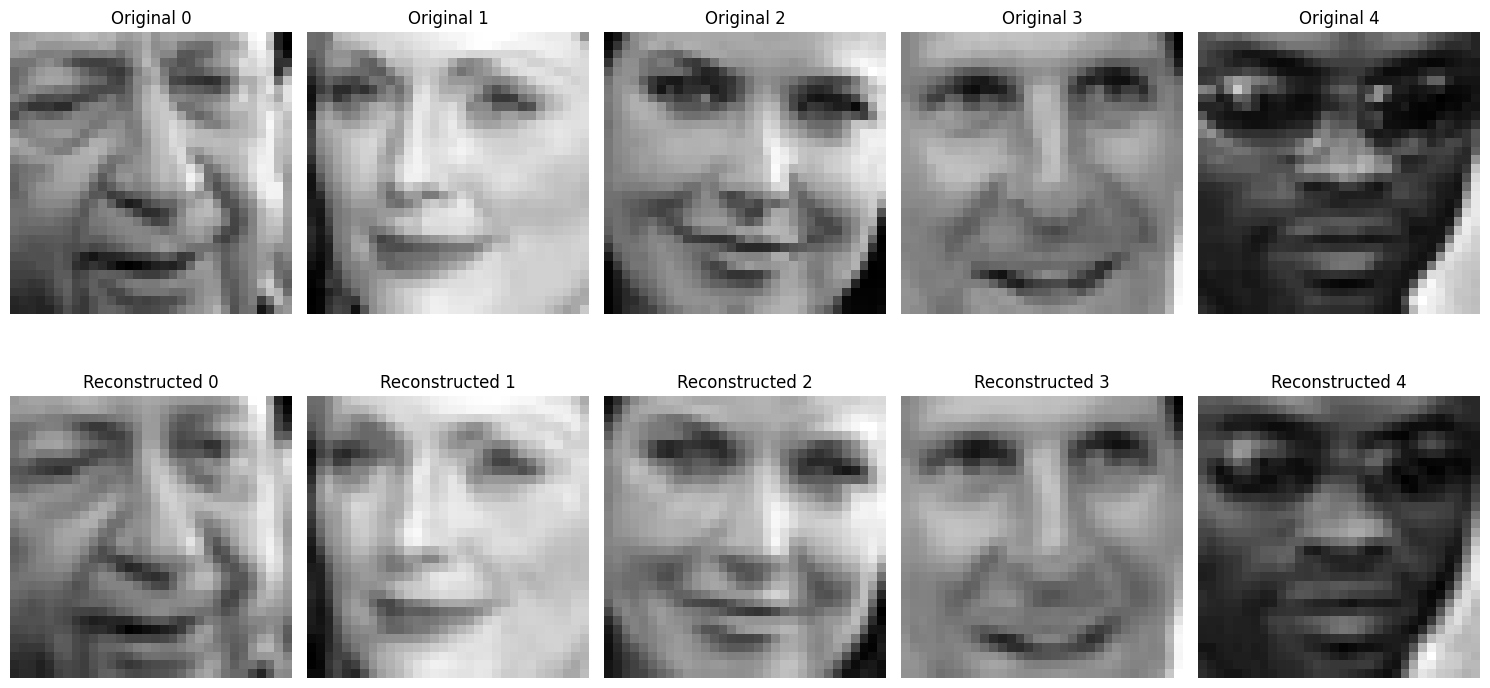

In [20]:
# Muestra 5 caras del conjunto de test y sus respectivas reconstrucciones

# Redimensionamos los datos
test = np.reshape(test, (test.shape[0], 32, 32))
Test_recovered = np.reshape(Test_recovered, (Test_recovered.shape[0], 32, 32))

# Número de caras que se van a mostrar
n_caras = 5

plt.figure(figsize=(15, 8))

for i in range(n_caras):
    # Mostramos la imagen original
    plt.subplot(2, n_caras, i + 1)
    plt.imshow(test[i].T, cmap="gray")
    plt.title(f"Original {i}")
    plt.axis("off")

    # Mostramos la imagen reconstruida
    plt.subplot(2, n_caras, n_caras + i + 1)
    plt.imshow(Test_recovered[i].T, cmap="gray")
    plt.title(f"Reconstructed {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Detección de anomalías

En el conjunto de test hay una imagen anómala que no se corresponde con el resto del dataset. ¿Como la identificarías automaticamente utilizando lo que has aprendido?

> 📝 **Pregunta 22.** Identifica y muestra la anomalía oculta en el conjunto de test. Muestra también la reconstrucción que hemos obtenido de esa anomalía.

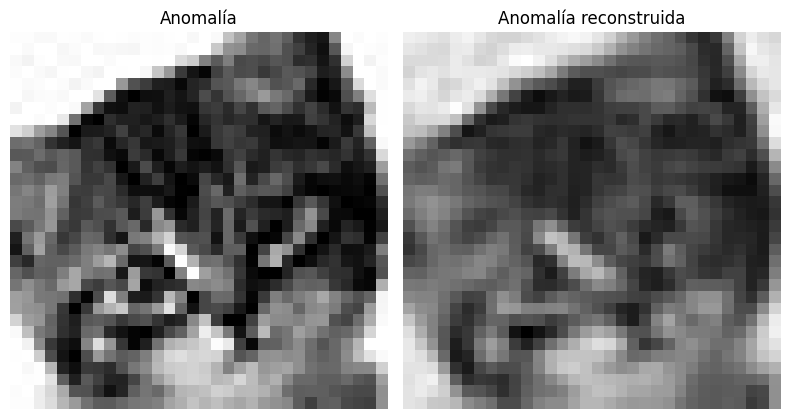

In [21]:
# Identifica la anomalía en el conjunto de test.
mse = np.mean((test - Test_recovered) ** 2, axis=(1, 2))
indexes_by_mse = np.argsort(mse)
original_anomaly, reconstructed_anomaly = (
    test[indexes_by_mse[-1]].T,
    Test_recovered[indexes_by_mse[-1]].T,
)

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_anomaly, cmap="gray")
plt.title("Anomalía")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_anomaly, cmap="gray")
plt.title("Anomalía reconstruida")
plt.axis("off")

plt.tight_layout()
plt.show()

> 📝 **Pregunta 23.** ¿Qué es lo que nos permite identificar la imagen como anomalía? ¿Por qué se reconstruye de esa manera?

> **Respuesta:**
Lo que nos permite identificar a la imagen como anómala es el error de **MSE**. La intuición detrás de esta técnica es la siguiente: Si se extraen las componentes principales, en este caso las $250$ primeras componentes, estas deberían representar las dimensiones principales de la variabilidad en los datos normales. Por lo tanto, cuando una imagen se proyecta en este subespacio y se reconstruye a partir de estas componentes principales, estas deberían representar las características principales que definen las caras humanas normales dentro del dataset. La reconstrucción será precisa si la imagen se ajusta bien a las características comunes de las caras humanas (ya que la mayoría de datos son caras humanas y por tanto el algoritmo extrae información de las caras). Sin embargo, si una cara contiene características atípicas o anómalas (como deformaciones, ruido, o elementos que no pertenecen a una cara humana típica), estas no estarán bien representadas por las componentes principales. En el caso mostrado, la reconstrucción es deficiente en los detalles específicos de la anomalía, lo que genera una discrepancia visual clara y un error mayor, permitiendo identificar la imagen como anómala. La reconstrucción está limitada a lo que el subespacio generado por las componentes principales puede expresar. Si una imagen contiene características que no encajan en este subespacio, como ruido, deformaciones o estructuras inusuales, estas características se "pierden" en la reconstrucción, resultando en una versión incompleta o distorsionada de la imagen original. Por ello esta imagen se reconstruye así.
De hecho, un ejercicio práctico muy interesante sería disminuir el número de componentes a usar. De esta forma, la imagen del gato trataría de reconstruirse formando una especie de cara humana distorsionada.